<a href="https://colab.research.google.com/github/pharringtonp19/housing-and-homelessness/blob/main/notebooks/JudgeIVSimplified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import Libraries**

In [82]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### **Parameters**

In [83]:
key = jax.random.PRNGKey(0)
n = 1000
j = 50

### **Functions**

In [84]:
def Treatment(j, key):
  return jax.random.choice(key, a=jnp.array([0, 1, 2, 3]), p=j)

def Outcome(treatment, key):
  return treatment + 0.1*jax.random.normal(key)

def Judge(key):
  j = jax.random.uniform(key, shape=(4,))
  return j/jnp.sum(j)

def regression(y, z):
  residual = z - jnp.mean(z)
  return jnp.linalg.lstsq(residual, y)[0][0]

def obs(key1, key2):
  k1, k2 = jax.random.split(key1)
  judge = Judge(key2)
  treatment = Treatment(judge, k1)
  outcome = Outcome(treatment, k2)
  return outcome, (treatment == 0).astype(jnp.float32), judge[0]

def sample_iid(n, key):
  k1, k2 = jax.random.split(key)
  ys, ds, zs = jax.vmap(obs)(jax.random.split(k1, n), jax.random.split(k2, n))
  return ys.reshape(-1,1), ds.reshape(-1,1), zs.reshape(-1,1)

def sample_cluster(n, j, key):
  k1, k2 = jax.random.split(key)
  cluster_keys = jnp.repeat(jax.random.split(k2, j), n // j, axis=0)
  ys, ds, zs = jax.vmap(obs)(jax.random.split(k1, n), cluster_keys)
  return ys.reshape(-1,1), ds.reshape(-1,1), zs.reshape(-1,1)

def iid_est(n, key):
  ys, _, zs =  sample_iid(n, key)
  return regression(ys, zs)

def cluster_est(n, j, key):
  ys, _, zs =  sample_cluster(n, j, key)
  return regression(ys, zs)

### **Cluster Simulation**

In [85]:
f_cluster = partial(cluster_est, n, j)
results_cluster = jax.vmap(f_cluster)(jax.random.split(key, 5000))

### **i.i.d Simulation**

In [86]:
f_iid = partial(iid_est, n)
results_iid = jax.vmap(f_iid)(jax.random.split(key, 5000))

### **Plots**

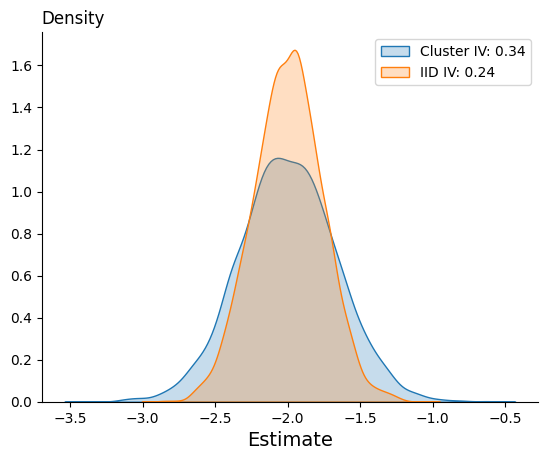

In [89]:
# Assuming results_cluster and results_iid are arrays or lists of data
sns.kdeplot(results_cluster.reshape(-1,), label=f"Cluster IV: {jnp.std(results_cluster):.2f}", shade=True)
sns.kdeplot(results_iid.reshape(-1,), label=f"IID IV: {jnp.std(results_iid):.2f}", shade=True)
# Add labels and show plot
plt.legend()
plt.title('Density', loc='left')
plt.xlabel("Estimate", size=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('')
plt.show()